Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt


Hyperparameters

In [2]:
r = 62
num_classes = 10 + r        # 72 classes
learning_rate = 0.01
epochs = 20
batch_size = 64
image_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Dataset

In [3]:
# dataset + dataloaders
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),          # [0,1]
])

train_dataset = torchvision.datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# Select only first 72 classes
def filter_classes(dataset, num_classes):
    indices = [i for i, (_, y) in enumerate(dataset) if y < num_classes]
    return Subset(dataset, indices)

train_dataset = filter_classes(train_dataset, num_classes)
test_dataset = filter_classes(test_dataset, num_classes)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



100%|██████████| 169M/169M [00:04<00:00, 41.9MB/s]


Scaled-ReLu

In [4]:
class ScaledReLU(nn.Module):
    def __init__(self, r):
        super().__init__()
        self.r = r

    def forward(self, x):
        return torch.maximum(torch.zeros_like(x), self.r * x)


Model

In [5]:
class MLP(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 64 * 3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.activation = activation

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


Training Function

In [6]:
def train_model(model):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    train_loss, train_acc, val_acc = [], [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = outputs.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

        val_acc.append(100 * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Loss: {train_loss[-1]:.4f} | "
              f"Train Acc: {train_acc[-1]:.2f}% | "
              f"Val Acc: {val_acc[-1]:.2f}%")

    return train_loss, train_acc, val_acc


Train ReLU

In [7]:
relu_model = MLP(nn.ReLU())
relu_loss, relu_train_acc, relu_val_acc = train_model(relu_model)


Epoch [1/20] | Loss: 4.2143 | Train Acc: 3.94% | Val Acc: 5.49%
Epoch [2/20] | Loss: 3.8842 | Train Acc: 8.13% | Val Acc: 9.88%
Epoch [3/20] | Loss: 3.6919 | Train Acc: 11.04% | Val Acc: 12.53%
Epoch [4/20] | Loss: 3.5763 | Train Acc: 13.07% | Val Acc: 13.92%
Epoch [5/20] | Loss: 3.4923 | Train Acc: 14.78% | Val Acc: 15.31%
Epoch [6/20] | Loss: 3.4297 | Train Acc: 16.09% | Val Acc: 16.08%
Epoch [7/20] | Loss: 3.3795 | Train Acc: 17.06% | Val Acc: 17.38%
Epoch [8/20] | Loss: 3.3356 | Train Acc: 18.11% | Val Acc: 17.21%
Epoch [9/20] | Loss: 3.2954 | Train Acc: 19.20% | Val Acc: 18.10%
Epoch [10/20] | Loss: 3.2598 | Train Acc: 19.85% | Val Acc: 19.44%
Epoch [11/20] | Loss: 3.2278 | Train Acc: 20.77% | Val Acc: 20.47%
Epoch [12/20] | Loss: 3.1951 | Train Acc: 21.33% | Val Acc: 20.67%
Epoch [13/20] | Loss: 3.1678 | Train Acc: 21.79% | Val Acc: 21.08%
Epoch [14/20] | Loss: 3.1386 | Train Acc: 22.43% | Val Acc: 21.99%
Epoch [15/20] | Loss: 3.1125 | Train Acc: 22.93% | Val Acc: 22.81%
Epoch [1

Train Scaled ReLU

In [8]:
scaled_relu_model = MLP(ScaledReLU(r))
scaled_loss, scaled_train_acc, scaled_val_acc = train_model(scaled_relu_model)


Epoch [1/20] | Loss: 733191780139.9618 | Train Acc: 1.36% | Val Acc: 1.39%
Epoch [2/20] | Loss: 4.2778 | Train Acc: 1.34% | Val Acc: 1.39%
Epoch [3/20] | Loss: 4.2777 | Train Acc: 1.32% | Val Acc: 1.39%
Epoch [4/20] | Loss: 4.2775 | Train Acc: 1.31% | Val Acc: 1.39%
Epoch [5/20] | Loss: 4.2774 | Train Acc: 1.28% | Val Acc: 1.39%
Epoch [6/20] | Loss: 4.2773 | Train Acc: 1.32% | Val Acc: 1.39%
Epoch [7/20] | Loss: 4.2773 | Train Acc: 1.32% | Val Acc: 1.39%
Epoch [8/20] | Loss: 4.2772 | Train Acc: 1.32% | Val Acc: 1.39%
Epoch [9/20] | Loss: 4.2771 | Train Acc: 1.28% | Val Acc: 1.39%
Epoch [10/20] | Loss: 4.2771 | Train Acc: 1.29% | Val Acc: 1.39%
Epoch [11/20] | Loss: 4.2770 | Train Acc: 1.34% | Val Acc: 1.39%
Epoch [12/20] | Loss: 4.2770 | Train Acc: 1.24% | Val Acc: 1.39%
Epoch [13/20] | Loss: 4.2769 | Train Acc: 1.36% | Val Acc: 1.39%
Epoch [14/20] | Loss: 4.2769 | Train Acc: 1.26% | Val Acc: 1.39%
Epoch [15/20] | Loss: 4.2769 | Train Acc: 1.27% | Val Acc: 1.39%
Epoch [16/20] | Loss: 4

Plot Results

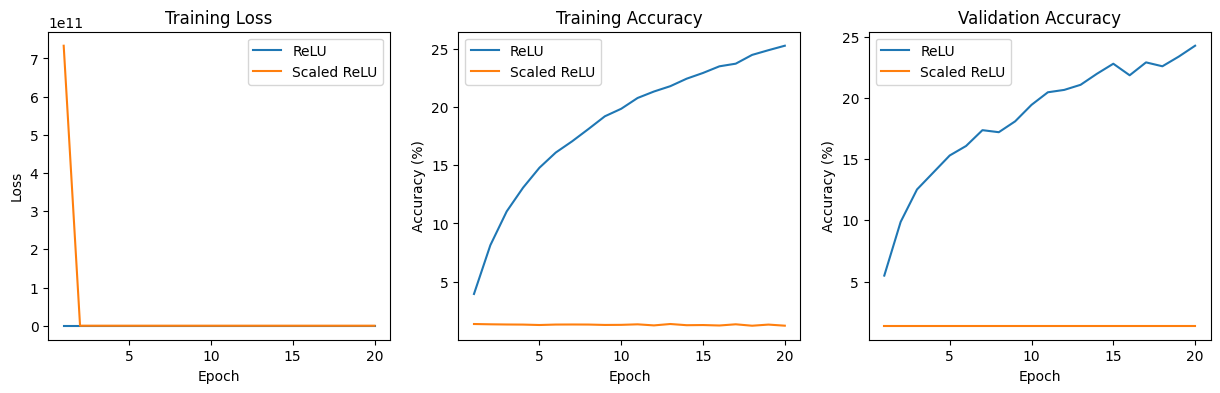

In [9]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(15, 4))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, relu_loss, label="ReLU")
plt.plot(epochs_range, scaled_loss, label="Scaled ReLU")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Training Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, relu_train_acc, label="ReLU")
plt.plot(epochs_range, scaled_train_acc, label="Scaled ReLU")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()

# Validation Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs_range, relu_val_acc, label="ReLU")
plt.plot(epochs_range, scaled_val_acc, label="Scaled ReLU")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()

plt.show()
